# WeatherNet

## Importing Required Libraries

In [2]:
import tensorflow as tf
from keras.layers import Input, Dense, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, UpSampling1D, UpSampling2D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime as dt
import time
from math import ceil
import requests as req
import json
import pandas as pd
import pickle
import os
import geopy
from geopy import distance
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import random
%pylab inline

2023-10-11 04:57:04.573618: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-11 04:57:04.895705: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-11 04:57:04.896903: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 04:57:05.971361: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/aamod/.local/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['ceil', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Utils

In [3]:
def mkdate(ts):
    return dt.datetime.fromtimestamp(
        int(ts)
    ).strftime('%Y-%m-%d')

def plot_examples(input, decoded, test_samples, n):
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, test_samples, ceil(test_samples/n)))):
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(input[int(idx)])
        ax.get_xaxis().set_visible(False)
        

        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(decoded[int(idx)])
        ax.get_xaxis().set_visible(False)
        
        
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

## Datasets retrieval & EDA

In [4]:
fname = './NW/ground_stations/NW_ground_stations_2018/NW2018.csv'
df = pd.read_csv(fname)

In [5]:
df

,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
0,14066001,49.330,-0.430,2.0,20180101 00:00,240.0,8.2,0.0,84.0,276.75,279.25,NaN
1,14126001,49.150,0.040,125.0,20180101 00:00,NaN,NaN,0.0,98.0,278.75,279.05,NaN
2,14137001,49.180,-0.460,67.0,20180101 00:00,250.0,10.7,0.0,85.0,278.15,280.55,100690.0
3,14216001,48.928,-0.149,155.0,20180101 00:00,240.0,5.4,0.0,77.0,276.45,280.25,NaN
4,14296001,48.790,-1.040,336.0,20180101 00:00,NaN,NaN,0.0,NaN,NaN,278.35,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
22034566,86137003,47.035,0.098,96.0,20181231 23:54,40.0,2.9,0.0,88.0,278.85,280.75,NaN
22034567,86165005,46.412,0.841,153.0,20181231 23:54,60.0,3.3,0.0,95.0,278.85,279.55,NaN
22034568,86272002,46.839,0.457,120.0,20181231 23:54,NaN,NaN,0.0,NaN,NaN,NaN,NaN
22034569,91200002,48.526,1.993,116.0,20181231 23:54,270.0,0.8,0.0,96.0,279.75,280.35,NaN


In [6]:
df.isna().sum()*100/df.shape[0]

number_sta     0.000000
lat            0.000000
lon            0.000000
height_sta     0.000000
date           0.000000
dd            39.055460
ff            39.023283
precip         5.805091
hu            39.862142
td            39.874405
t             13.132518
psl           79.970606
dtype: float64

### GeoStation Mapping for Given Parameters

In [7]:
date = '20180101 00:00'
d_sub = df[df['date'] == date]
d_sub

,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
0,14066001,49.330,-0.430,2.0,20180101 00:00,240.0,8.2,0.0,84.0,276.75,279.25,NaN
1,14126001,49.150,0.040,125.0,20180101 00:00,NaN,NaN,0.0,98.0,278.75,279.05,NaN
2,14137001,49.180,-0.460,67.0,20180101 00:00,250.0,10.7,0.0,85.0,278.15,280.55,100690.0
3,14216001,48.928,-0.149,155.0,20180101 00:00,240.0,5.4,0.0,77.0,276.45,280.25,NaN
4,14296001,48.790,-1.040,336.0,20180101 00:00,NaN,NaN,0.0,NaN,NaN,278.35,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
243,86137003,47.035,0.098,96.0,20180101 00:00,200.0,2.5,0.0,80.0,277.15,280.35,NaN
244,86165005,46.412,0.841,153.0,20180101 00:00,240.0,3.4,0.0,78.0,277.65,281.25,NaN
245,86272002,46.840,0.450,120.0,20180101 00:00,NaN,NaN,0.0,NaN,NaN,280.25,NaN
246,91200002,48.527,1.995,116.0,20180101 00:00,250.0,5.2,0.0,73.0,277.05,281.65,NaN


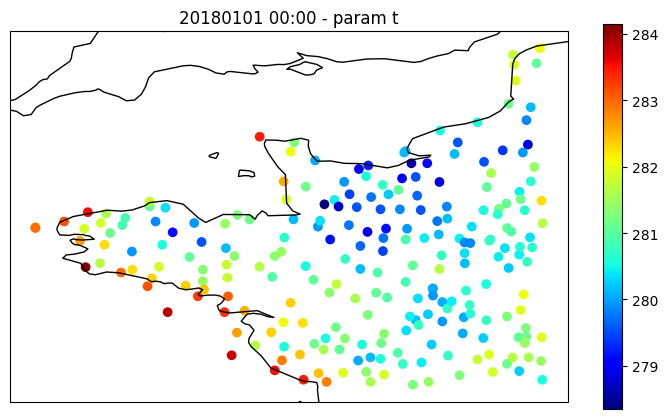

In [14]:
param = 't'
lllat = 46.25
urlat = 51.896
lllon = -5.842
urlon = 2
extent = [lllon, urlon, lllat, urlat]

fig = plt.figure(figsize=(9,5))

ax = plt.axes(projection=ccrs.PlateCarree())

plt.scatter(d_sub['lon'], d_sub['lat'], c=d_sub[param], cmap='jet')  # Plot
plt.colorbar()
plt.title(date+' - param '+param)

ax.coastlines(resolution='50m', linewidth=1)
ax.add_feature(cfeature.BORDERS.with_scale('50m'))

plt.show()

## Segmenting Datasets specific to Geostations

In [16]:
stations = df[['number_sta', 'lat', 'lon']].groupby('number_sta', as_index=False).mean()
stations

,number_sta,lat,lon
0,14066001,49.333064,-0.430766
1,14126001,49.146191,0.041523
2,14137001,49.180000,-0.456935
3,14216001,48.928000,-0.149000
4,14296001,48.793821,-1.037707
...,...,...,...
266,86137003,47.035000,0.098000
267,86165005,46.412000,0.841000
268,86272002,46.839245,0.455285
269,91200002,48.526096,1.993192


**To find closest station**

In [17]:
def get_closest_station(latitude, longitude, rank=1):
    
    # Calculate distance from each station (km)
    distances = []
    for i in range(len(stations)):
        coord1 = (latitude, longitude)
        coord2 = (stations.loc[i, 'lat'], stations.loc[i, 'lon'])
        distances.append(distance.geodesic(coord1, coord2).km)
    station_distances = pd.concat([stations, pd.Series(distances, name='distance')], axis=1).sort_values(by='distance')
    
    station_id = int(station_distances.iloc[rank - 1]['number_sta'])
    station_lat = float(station_distances.iloc[rank - 1]['lat'])
    station_lon = float(station_distances.iloc[rank - 1]['lon'])
    station_dist = int(station_distances.iloc[rank - 1]['distance'])
    
    return station_id, station_lat, station_lon, station_dist

**To fill in Missing Data**

In [18]:
def fill_in_missing_records(df_station):
    df_station = df_station.copy()
    
    full_time_range = pd.Series(pd.date_range(dt.datetime(2018, 1, 1, hour=0, minute=0), periods=87600, freq='6min'), name='date')

    r = 2
    while len(df_station) != 87600:
        
        # Datetimes
        current_times = df_station['date']
        missing_times = full_time_range[full_time_range.isin(current_times) == False]

        # Get the missing data
        new_id = get_closest_station(df_station['lat'].values[0], df_station['lon'].values[0], rank=r)[0]
        # new_id = 29075001
        new_data_station = df[df['number_sta'] == new_id].reset_index(drop=True)
        missing_data = new_data_station[pd.to_datetime(new_data_station['date']).isin(missing_times)]

        # Concatenate
        df_station = pd.concat([df_station, missing_data], axis=0)
        
        r += 1

    df_station = df_station.sort_values(by='date').reset_index(drop=True)
    
    return df_station

**To downsample dataset with respect to time**

In [19]:
def datetime_downsampling(df, start_hour, day_step):
    
    keep_index = [x + 10 * start_hour for x in range(87600) if x % (240 * day_step) == 0]
    df = df.iloc[keep_index].reset_index(drop=True)
    
    return df

### Finding Station closest to a location

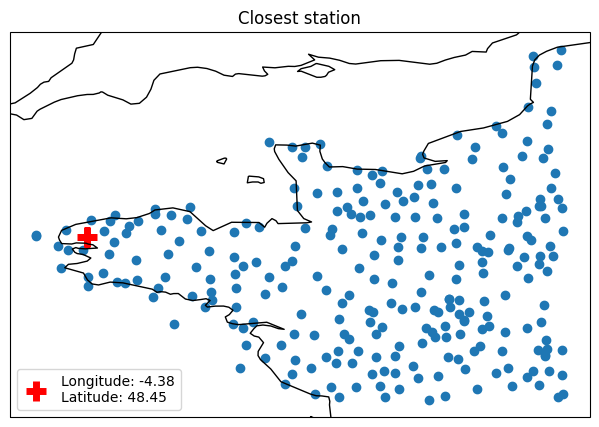

The closest station at has id 29075001.
Distance = 5 km


In [56]:
LATITUDE = 48.50
LONGITUDE = -4.40

station_id, station_lat, station_lon, station_dist = get_closest_station(LATITUDE, LONGITUDE)

fig = plt.figure(figsize=(9,5))

extent = [-5.85, 2.00, 46.25, 51.90]
ax = plt.axes(projection=ccrs.PlateCarree())

plt.scatter(stations['lon'], stations['lat'])
plt.scatter(station_lon, station_lat, c='r', marker='+', s=200, linewidth=5,
            label="Longitude: {:.2f}\nLatitude: {:.2f}".format(station_lon, station_lat))

plt.title("Closest station")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='lower left')

ax.coastlines(resolution='50m', linewidth=1)
ax.add_feature(cfeature.BORDERS.with_scale('50m'))

plt.show()

print("The closest station at has id {}.\nDistance = {} km".format(station_id, station_dist))

### Choosing 2 geological stations as nodes

In [57]:
data_station1 = df[df['number_sta']==station_id].reset_index(drop=True)
data_station1

,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
0,29075001,48.45,-4.380,98.0,20180101 00:00,260.0,7.4,0.0,74.0,277.45,281.85,101020.0
1,29075001,48.45,-4.380,98.0,20180101 00:06,260.0,8.2,0.0,74.0,277.35,281.75,101020.0
2,29075001,48.45,-4.380,98.0,20180101 00:12,250.0,7.4,0.0,75.0,277.35,281.55,101010.0
3,29075001,48.45,-4.380,98.0,20180101 00:18,250.0,7.0,0.0,76.0,277.45,281.45,101010.0
4,29075001,48.45,-4.380,98.0,20180101 00:24,260.0,7.4,0.0,76.0,277.75,281.75,101010.0
...,...,...,...,...,...,...,...,...,...,...,...,...
87465,29075001,48.45,-4.383,98.0,20181231 23:30,30.0,1.8,0.0,81.0,278.25,281.35,103790.0
87466,29075001,48.45,-4.383,98.0,20181231 23:36,30.0,1.4,0.0,82.0,278.35,281.25,103790.0
87467,29075001,48.45,-4.383,98.0,20181231 23:42,30.0,1.6,0.0,81.0,278.15,281.25,103800.0
87468,29075001,48.45,-4.383,98.0,20181231 23:48,30.0,1.9,0.0,80.0,278.15,281.35,103800.0


In [58]:
LATITUDE = 48.030
LONGITUDE = -0.750

station_id, station_lat, station_lon, station_dist = get_closest_station(LATITUDE, LONGITUDE)

data_station2 = df[df['number_sta']==station_id].reset_index(drop=True)
data_station2

,number_sta,lat,lon,height_sta,date,dd,ff,precip,hu,td,t,psl
0,53130008,48.030,-0.750,100.0,20180101 00:00,240.0,6.3,0.0,79.0,277.35,280.75,101090.0
1,53130008,48.030,-0.750,100.0,20180101 00:06,240.0,6.0,0.0,80.0,277.55,280.75,101100.0
2,53130008,48.030,-0.750,100.0,20180101 00:12,240.0,5.9,0.0,80.0,277.45,280.65,101110.0
3,53130008,48.030,-0.750,100.0,20180101 00:18,240.0,5.6,0.0,80.0,277.55,280.75,101110.0
4,53130008,48.030,-0.750,100.0,20180101 00:24,230.0,5.4,0.0,80.0,277.45,280.65,101120.0
...,...,...,...,...,...,...,...,...,...,...,...,...
87390,53130008,48.031,-0.747,100.0,20181231 23:30,40.0,2.0,0.0,86.0,278.65,280.85,103720.0
87391,53130008,48.031,-0.747,100.0,20181231 23:36,20.0,2.2,0.0,84.0,278.45,280.95,103720.0
87392,53130008,48.031,-0.747,100.0,20181231 23:42,20.0,2.5,0.0,84.0,278.55,281.05,103720.0
87393,53130008,48.031,-0.747,100.0,20181231 23:48,20.0,2.5,0.0,84.0,278.55,281.05,103720.0


**To fill in missing data and replace NaN values with column average**

In [59]:
data_station1.isna().sum()

number_sta     0
lat            0
lon            0
height_sta     0
date           0
dd             9
ff             9
precip        24
hu             3
td             3
t              3
psl            3
dtype: int64

In [60]:
data_station2.isna().sum()

number_sta     0
lat            0
lon            0
height_sta     0
date           0
dd            11
ff            11
precip        15
hu             3
td             3
t              3
psl            3
dtype: int64

In [61]:
data_station1 = fill_in_missing_records(data_station1)
data_station2 = fill_in_missing_records(data_station2)

In [66]:
mean = data_station1.iloc[:, 5:].mean()
data_station1 = data_station1.fillna(mean)

mean = data_station2.iloc[:, 5:].mean()
data_station2 = data_station2.fillna(mean)

In [67]:
data_station1.to_csv('datastation1.csv', sep=',', index=False, encoding='utf-8')
data_station2.to_csv('datastation2.csv', sep=',', index=False, encoding='utf-8')

In [70]:
scaler = StandardScaler()
window_length = 5
ds = np.append(data_station1.values[:, 5:], data_station2.values[:, 5:], axis=0)

In [71]:
X = []
for i in tqdm(range(window_length, len(ds))):
    X.append(scaler.fit_transform(ds[i-window_length:i, :]))

100%|██████████| 175195/175195 [00:57<00:00, 3024.36it/s]


In [73]:
X = np.array(X)
X.shape

(175195, 5, 7)

## Model Implementation

In [74]:
n_features = 7
encoding_dim = 5
test_perc = 0.1
test_samples = int(test_perc*X.shape[0])

x_test = X[-test_samples:]
x_train = X[:-test_samples]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [132]:
x_train_deep = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_deep = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

input_window = Input(shape=(window_length*n_features,))

x = Dense(16, activation="relu")(input_window)
x = BatchNormalization()(x)
x = Dense(8, activation='relu')(x)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim, activation='relu', name='encoded_out')(x)

x = Dense(8, activation="relu", name='decoder_in')(encoded)
x = BatchNormalization()(x)
x = Dense(16, activation="relu")(x)
x = BatchNormalization()(x)
decoded = Dense(window_length*n_features, activation=tf.keras.layers.LeakyReLU(alpha=0.1))(x)

autoencoder = Model(input_window, decoded)

autoencoder.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 35)]              0         
                                                                 
 dense_13 (Dense)            (None, 16)                576       
                                                                 
 batch_normalization_4 (Bat  (None, 16)                64        
 chNormalization)                                                
                                                                 
 dense_14 (Dense)            (None, 8)                 136       
                                                                 
 batch_normalization_5 (Bat  (None, 8)                 32        
 chNormalization)                                                
                                                                 
 encoded_out (Dense)         (None, 5)                 45 

In [109]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())
history = autoencoder.fit(x_train_deep, x_train_deep,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_deep, x_test_deep))

Epoch 1/100
1232/1232 [==============================] - 3s 1ms/step - loss: 0.6291 - val_loss: 0.5111
Epoch 2/100
1232/1232 [==============================] - 2s 1ms/step - loss: 0.4827 - val_loss: 0.4161
Epoch 3/100
1232/1232 [==============================] - 1s 1ms/step - loss: 0.4237 - val_loss: 0.3848
Epoch 4/100
1232/1232 [==============================] - 2s 1ms/step - loss: 0.4079 - val_loss: 0.3739
Epoch 5/100
1232/1232 [==============================] - 1s 1ms/step - loss: 0.4006 - val_loss: 0.3671
Epoch 6/100
1232/1232 [==============================] - 2s 1ms/step - loss: 0.3978 - val_loss: 0.3644
Epoch 7/100
1232/1232 [==============================] - 2s 2ms/step - loss: 0.3939 - val_loss: 0.3600
Epoch 8/100
1232/1232 [==============================] - 2s 2ms/step - loss: 0.3892 - val_loss: 0.3550
Epoch 9/100
1232/1232 [==============================] - 2s 2ms/step - loss: 0.3856 - val_loss: 0.3540
Epoch 10/100
1232/1232 [==============================] - 2s 2ms/step - l

In [111]:
decoded_flat = autoencoder.predict(x_test_deep)
decoded_stocks = decoded_flat.reshape(decoded_flat.shape[0], window_length, n_features)

  1/548 [..............................] - ETA: 9s

548/548 [==============================] - 0s 822us/step


In [125]:
decoded_flat

array([[-0.28007966,  1.2059895 , -0.00572845, ..., -1.1729993 ,
        -1.4219807 ,  1.3829644 ],
       [-0.7196179 , -0.8346734 , -0.00844724, ..., -0.555847  ,
        -1.0417323 ,  1.4333138 ],
       [-0.9178854 , -0.8392348 , -0.0272771 , ...,  1.1046586 ,
        -0.92841595,  1.2560232 ],
       ...,
       [ 0.72301996, -0.8311497 , -0.0018898 , ..., -0.8546408 ,
        -0.42295858, -0.48219442],
       [ 0.06232595, -0.79492337, -0.00300287, ..., -0.7862745 ,
         0.691065  , -0.48176336],
       [ 0.6199602 , -0.7389794 , -0.00588114, ..., -0.6580171 ,
         1.0708158 , -0.54689795]], dtype=float32)

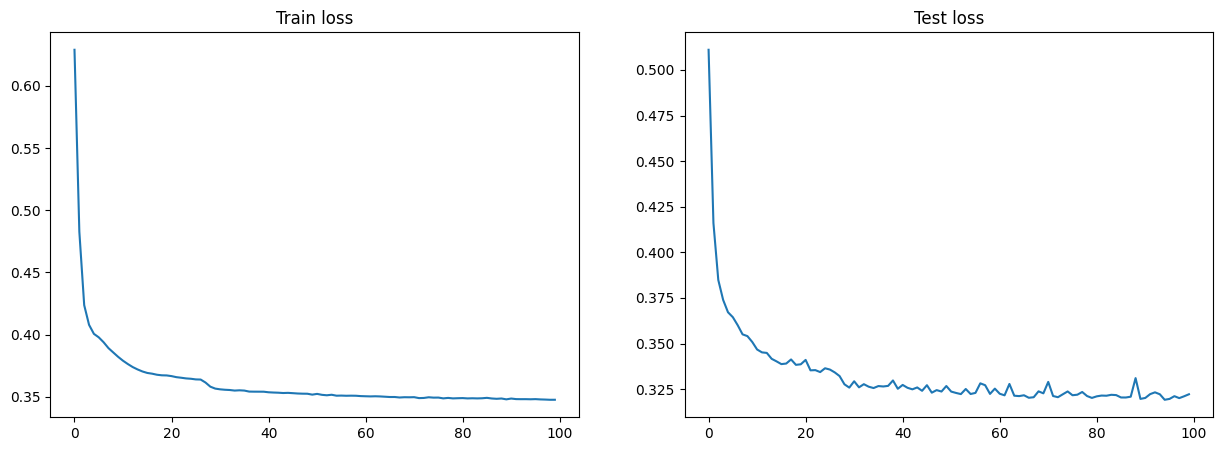

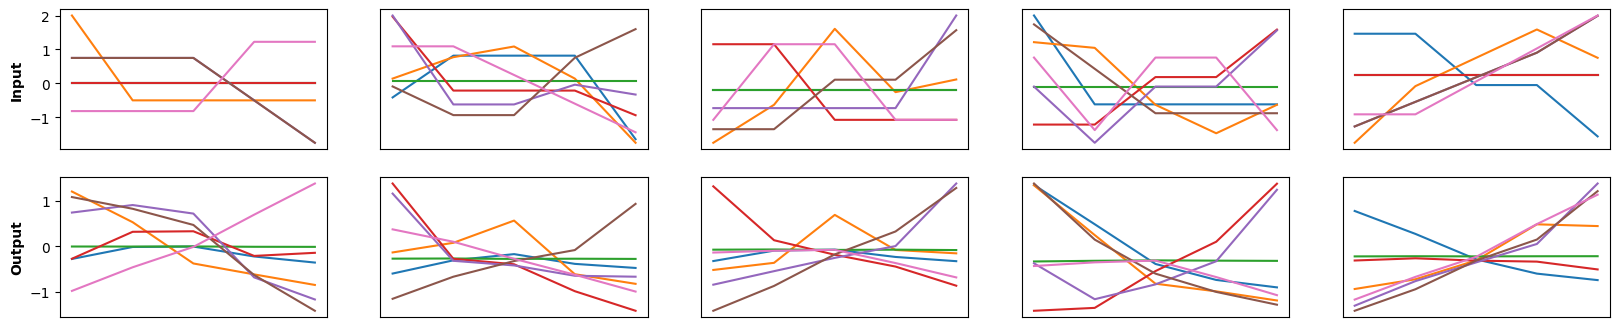

In [112]:
plot_history(history)
plot_examples(x_test, decoded_stocks, test_samples, n=5)

### Comparison of Original and Reconstructed Data

In [113]:
final = decoded_stocks[0, 0, :].reshape(1, -1)
for i in range(1, decoded_stocks.shape[0]-1):
    final = np.append(final, decoded_stocks[i, 0, :].reshape(1, -1), axis=0)
print(final.shape)
print(decoded_stocks[decoded_stocks.shape[0]-1, :, :].shape)
final = np.append(final, decoded_stocks[decoded_stocks.shape[0]-1, :, :], axis=0)
final.shape

(17518, 7)
(5, 7)


(17523, 7)

In [114]:
final_test = x_test[0, 0, :].reshape(1, -1)
for i in range(1, x_test.shape[0]-1):
    final_test = np.append(final_test, x_test[i, 0, :].reshape(1, -1), axis=0)
print(final_test.shape)
print(x_test[x_test.shape[0]-1, :, :].shape)
final_test = np.append(final_test, x_test[x_test.shape[0]-1, :, :], axis=0)
final_test.shape

(17518, 7)
(5, 7)


(17523, 7)

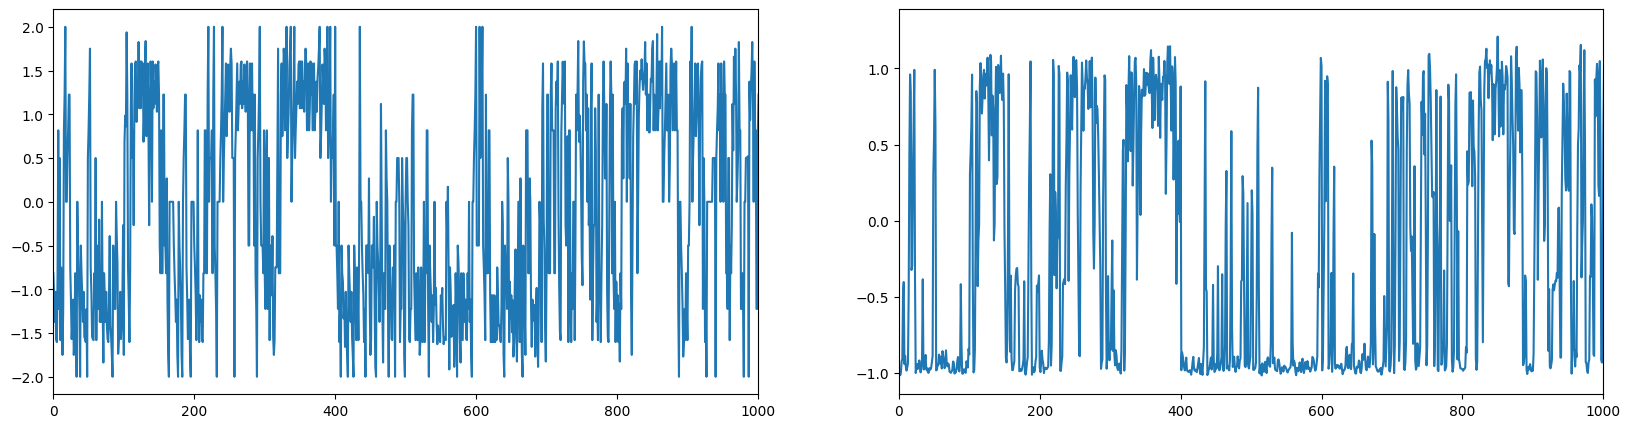

In [118]:
plt.figure(figsize=(20, 5))
ind = [i for i in range(final.shape[0])]
plt.subplot(1, 2, 1)
plt.xlim(0, 1000)
plt.plot(final_test[:, 6])
plt.subplot(1, 2, 2)
plt.xlim(0, 1000)
plt.plot(final[:, 6])

## Encoded Data Extraction

In [119]:
bottleneck_output = autoencoder.get_layer('encoded_out').output
model_encoder = tf.keras.models.Model(inputs = autoencoder.input, outputs = bottleneck_output)
bottleneck_predictions = model_encoder.predict(x_test_deep)
bottleneck_predictions.shape

548/548 [==============================] - 0s 533us/step


(17519, 5)

In [141]:
data_station1_np = data_station1.values
data_station2_np = data_station2.values
np.save('data_station1.npy', data_station1_np)
np.save('data_station2.npy', data_station2_np)

In [120]:
np.save('encoder_output.npy', bottleneck_predictions)

## Decoding the Received Data File

In [121]:
decoder_in = np.load('encoder_output.npy')
decoder_in.shape

(17519, 5)

In [126]:
decoder_input = autoencoder.get_layer('decoder_in')
model_decoder = tf.keras.models.Model(inputs = decoder_input.input, outputs = autoencoder.output)
decoder_predictions = model_decoder.predict(decoder_in)
decoder_predictions

548/548 [==============================] - 0s 504us/step


array([[-0.28007966,  1.2059895 , -0.00572845, ..., -1.1729993 ,
        -1.4219807 ,  1.3829644 ],
       [-0.7196179 , -0.8346734 , -0.00844724, ..., -0.555847  ,
        -1.0417323 ,  1.4333138 ],
       [-0.9178854 , -0.8392348 , -0.0272771 , ...,  1.1046586 ,
        -0.92841595,  1.2560232 ],
       ...,
       [ 0.72301996, -0.8311497 , -0.0018898 , ..., -0.8546408 ,
        -0.42295858, -0.48219442],
       [ 0.06232595, -0.79492337, -0.00300287, ..., -0.7862745 ,
         0.691065  , -0.48176336],
       [ 0.6199602 , -0.7389794 , -0.00588114, ..., -0.6580171 ,
         1.0708158 , -0.54689795]], dtype=float32)